In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
data_dir = "model_outputs/2023_05_11:16_32_00/"

In [3]:
os.listdir(data_dir)

['2023_05_11:16_35_34',
 '2023_05_11:16_34_35',
 '2023_05_11:16_33_36',
 '2023_05_11:16_33_55',
 '2023_05_11:16_32_38',
 '2023_05_11:16_32_19',
 '2023_05_11:16_35_54',
 '2023_05_11:16_33_17',
 '2023_05_11:16_34_54',
 '2023_05_11:16_34_15',
 '2023_05_11:16_32_57',
 '2023_05_11:16_35_14']

In [4]:
def aggregate_result(df, index):
    agg_df = df.groupby("epoch").mean()
    agg_df.drop("fold", axis=1, inplace=True)
    agg_df["config_index"] = index
    return agg_df


def plot_single_config(idx, data_dir):
    # idx references the index of the global configuration (i.e. ablation-setting)

    # model_outputs/study/[ablation_idx]/[config_idx]

    config_dir = os.listdir(data_dir)[idx]

    dfs = {}
    configurations = {}
    for config_index in range(len(os.listdir(data_dir + config_dir))):
        df = pd.read_csv(
            data_dir + config_dir + "/" + str(config_index) + "/results.csv"
        )
        dfs[config_index] = df

        with open(
            data_dir + config_dir + "/" + str(config_index) + "/parameters.json", "r"
        ) as file:
            for line in file:
                conf = json.loads(line)

        configurations[config_index] = conf

    for cidx, conf in configurations.items():
        print(cidx)
        print(conf)
        print()
        print()
        print()

    plt.style.use("fivethirtyeight")
    for index, df in dfs.items():
        agg_df = aggregate_result(df, index)

        agg_df[["train_loss_median", "val_loss_median"]].plot(figsize=[16, 9])
        plt.ylim([60, 100])
        plt.show()

In [5]:
def get_best_model(idx, data_dir, eval_metrix="val_loss_median"):
    # idx references the index of the global configuration (i.e. ablation-setting)
    # model_outputs/study/[ablation_idx]/[config_idx]
    # This means that this function returns the best model for a given ablation study (fx excluding channel 0 or channel 1 or satellite 2...)

    config_dir = os.listdir(data_dir)[idx]

    dfs = {}
    configurations = {}
    for config_index in range(len(os.listdir(data_dir + config_dir))):
        df = pd.read_csv(
            data_dir + config_dir + "/" + str(config_index) + "/results.csv"
        )
        dfs[config_index] = df

        with open(
            data_dir + config_dir + "/" + str(config_index) + "/parameters.json", "r"
        ) as file:
            for line in file:
                conf = json.loads(line)

        configurations[config_index] = conf

    cur_min = 1000
    cur_min_index = 99
    best_agg = None
    for index, df in dfs.items():
        agg_df = aggregate_result(df, index)
        m = agg_df[eval_metrix].min()
        if m < cur_min:
            cur_min = m
            cur_min_index = index
            best_agg = agg_df

    return best_agg, configurations[cur_min_index]

In [6]:
# WHICH MODEL DO YOU WANT TO PLOT

root_dir = "model_outputs/"

all_channels = "2023_05_07:17_16_42/"
satellites = "2023_05_07:15_16_57/"
satellites = "2023_05_09:12_18_08/"


data_path = root_dir + satellites

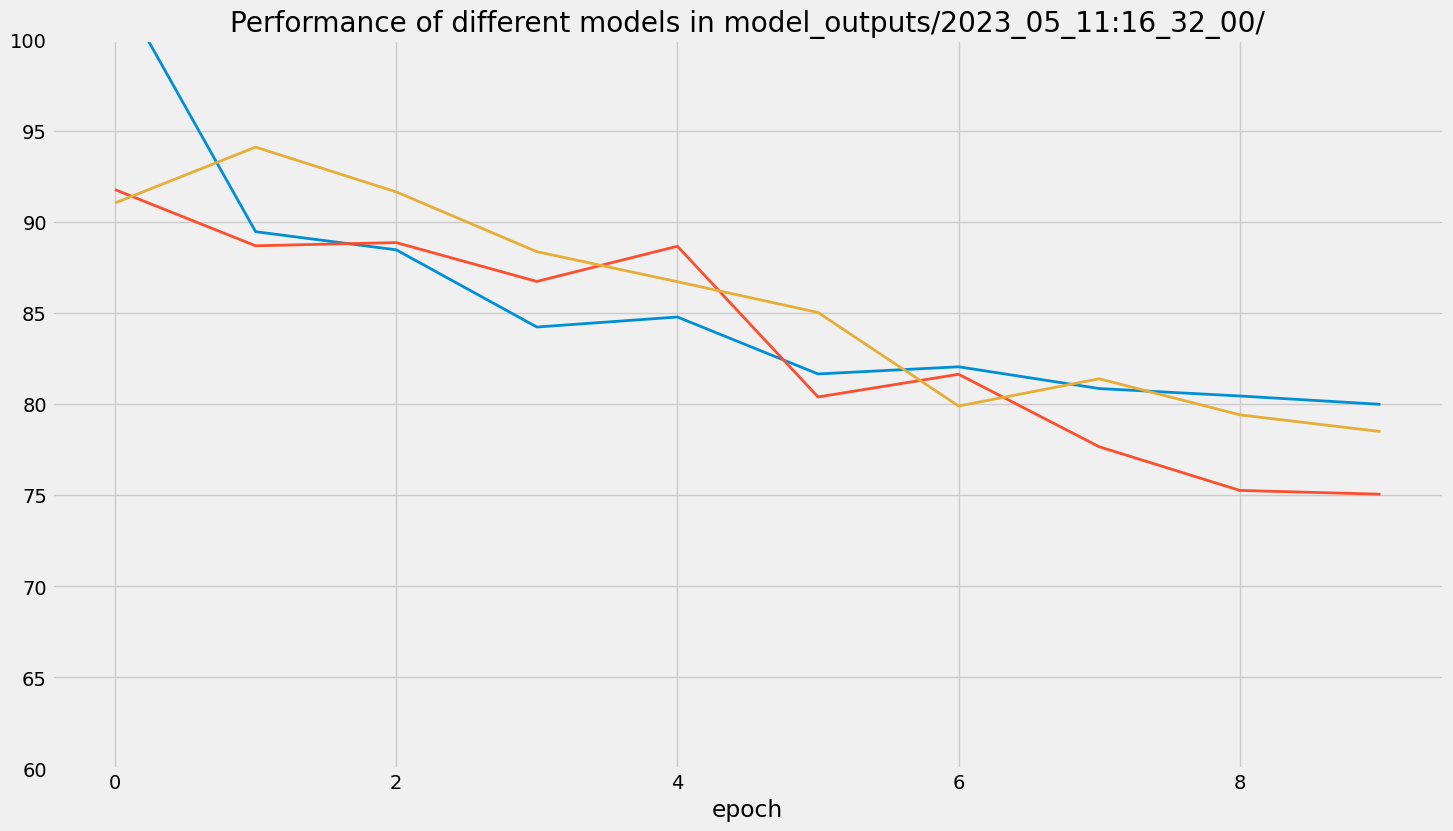

In [11]:
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=[16, 9])
for idx in range(3):
    res, conf = get_best_model(idx, data_dir)
    res["val_loss_median"].plot(linewidth=2)
    plt.ylim([60, 100])
plt.title("Performance of different models in " + data_dir)
plt.show()

## Plot Single Configuration (not that interesting)

0
{'num_input_channels': 15, 'conv_filters1': 4, 'conv_filters2': 8, 'conv_filters3': 4, 'num_dpoints': 5, 'exclude_layer': None, 'exclude_layer_name': 'No Layer Excluded', 'num_epochs': 10}



1
{'num_input_channels': 15, 'conv_filters1': 8, 'conv_filters2': 16, 'conv_filters3': 16, 'num_dpoints': 5, 'exclude_layer': None, 'exclude_layer_name': 'No Layer Excluded', 'num_epochs': 10}



2
{'num_input_channels': 15, 'conv_filters1': 16, 'conv_filters2': 32, 'conv_filters3': 16, 'num_dpoints': 5, 'exclude_layer': None, 'exclude_layer_name': 'No Layer Excluded', 'num_epochs': 10}





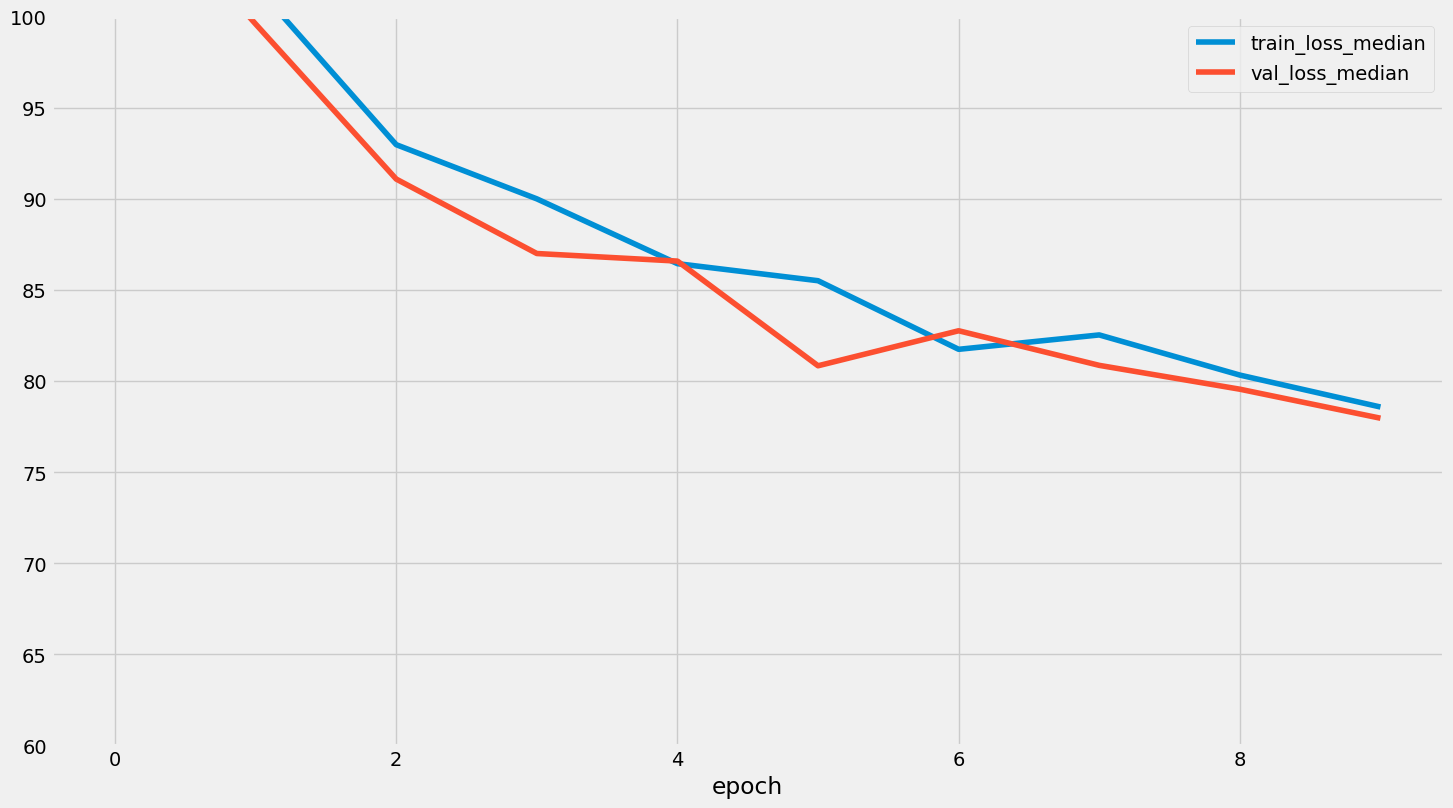

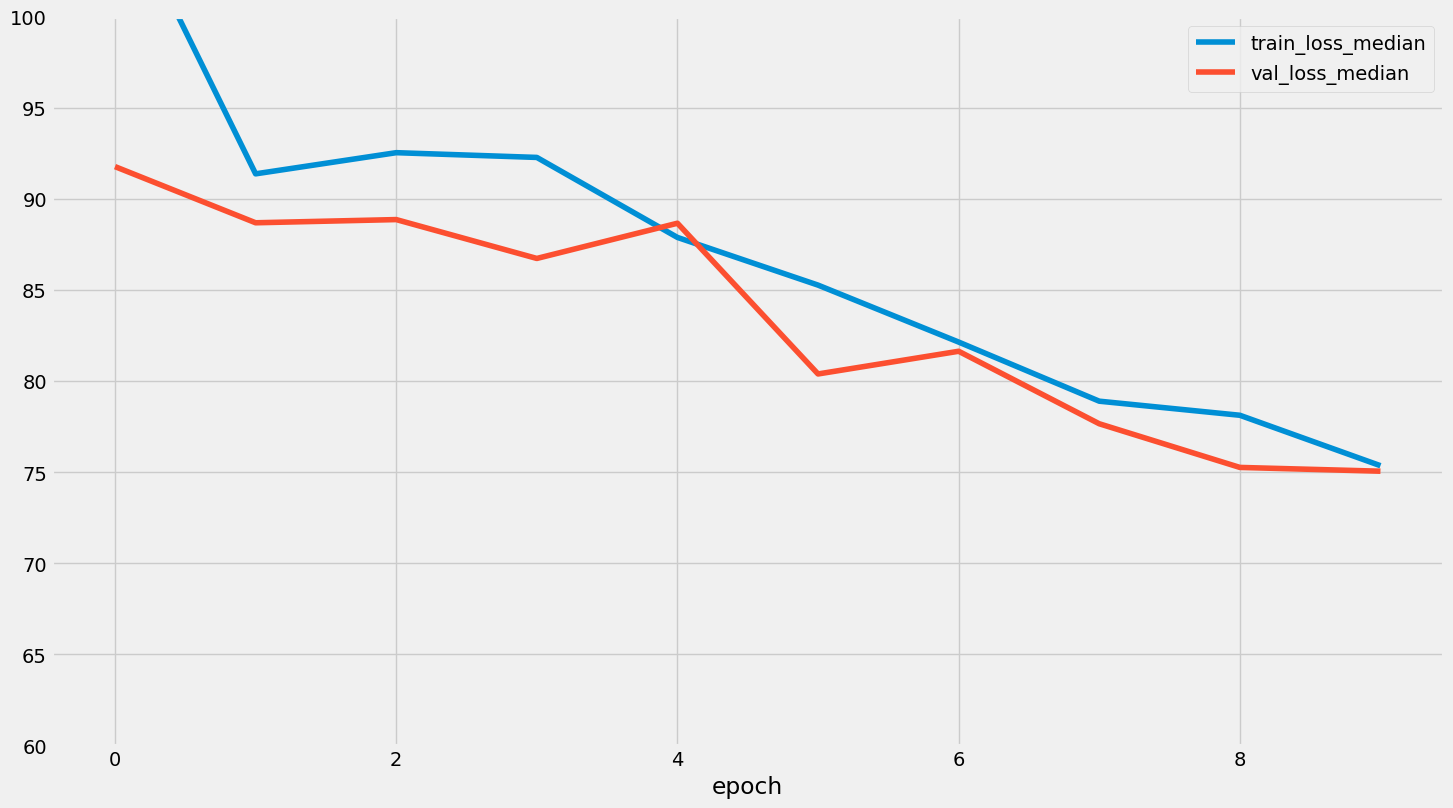

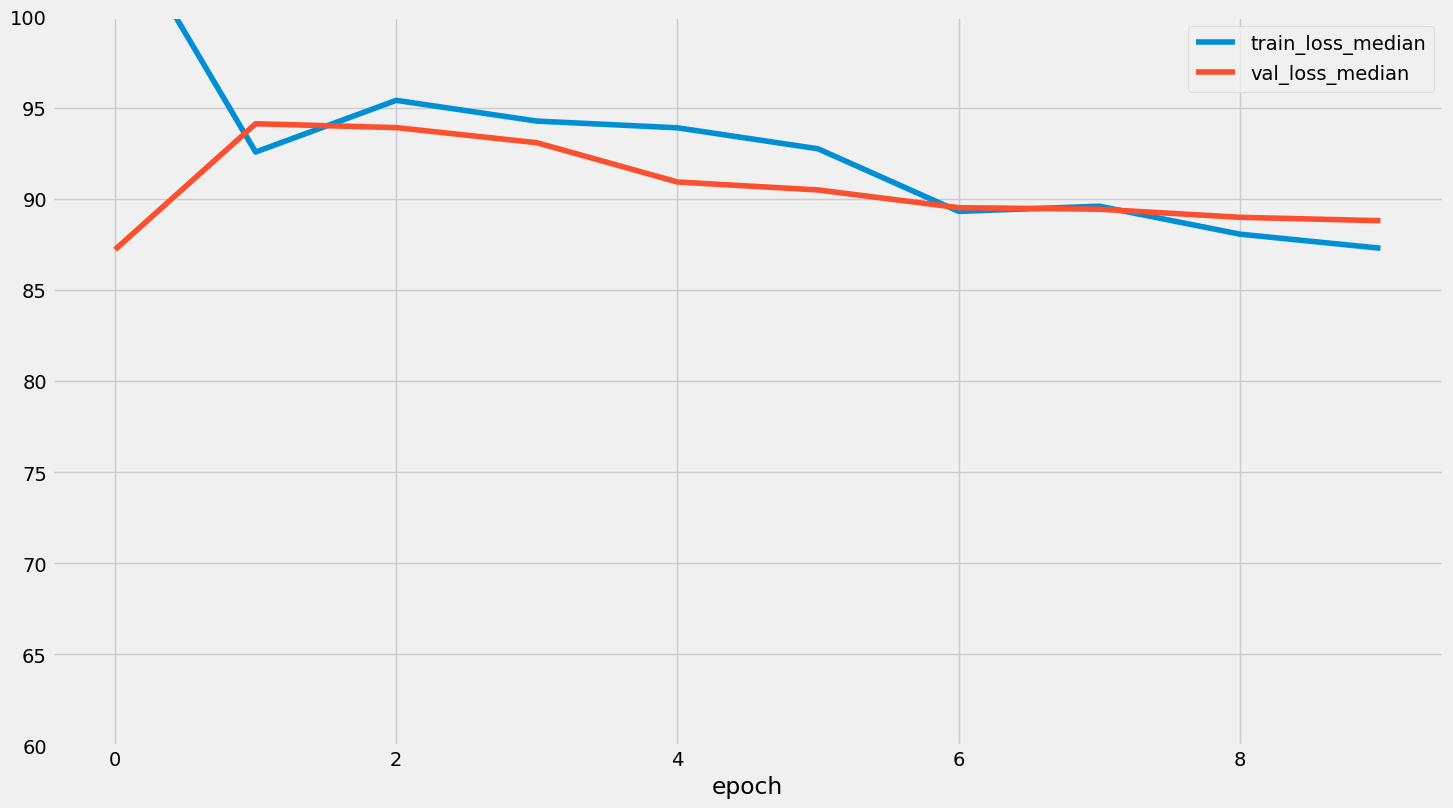

In [12]:
idx = 1
plot_single_config(idx, data_dir)

## Ablation Studies

In [14]:
channel_data_dir = root_dir + all_channels
satellite_data_dir = root_dir + satellites
o = get_best_model(5, data_dir)


def plot_ablation(
    data_dir, metric="val_loss_median", id_="exclude_layer_name", title="sometitle"
):
    result_dict = {}
    param_dict = {}

    average_validation_rmse_final_epoch = []
    excluded_channel = []

    for config_index in range(len(os.listdir(data_dir))):
        results, params = get_best_model(config_index, data_dir)

        result_dict[config_index] = results
        param_dict[config_index] = params

        final_epoch = params["num_epochs"] - 1
        perf = results.iloc[final_epoch]["val_loss_median"]

        average_validation_rmse_final_epoch.append(perf)
        excluded_channel.append(params[id_])

    plt.style.use("fivethirtyeight")

    plot_df = pd.DataFrame(
        {
            "excluded_channel": excluded_channel,
            "rmse": average_validation_rmse_final_epoch,
        }
    ).sort_values("rmse", ascending=False)
    #            kind = 'barh',

    # plt.figure(figsize=[16,9])

    plot_df.plot(kind="barh", x="excluded_channel", figsize=[16, 9], xlim=[40, 95])
    # plt.barh(excluded_channel,
    #         average_validation_rmse_final_epoch,
    #         linewidth = 2)
    plt.title(title)
    plt.tight_layout()
    plt.savefig("{}.png".format(title))

    plt.show()

    return param_dict, result_dict

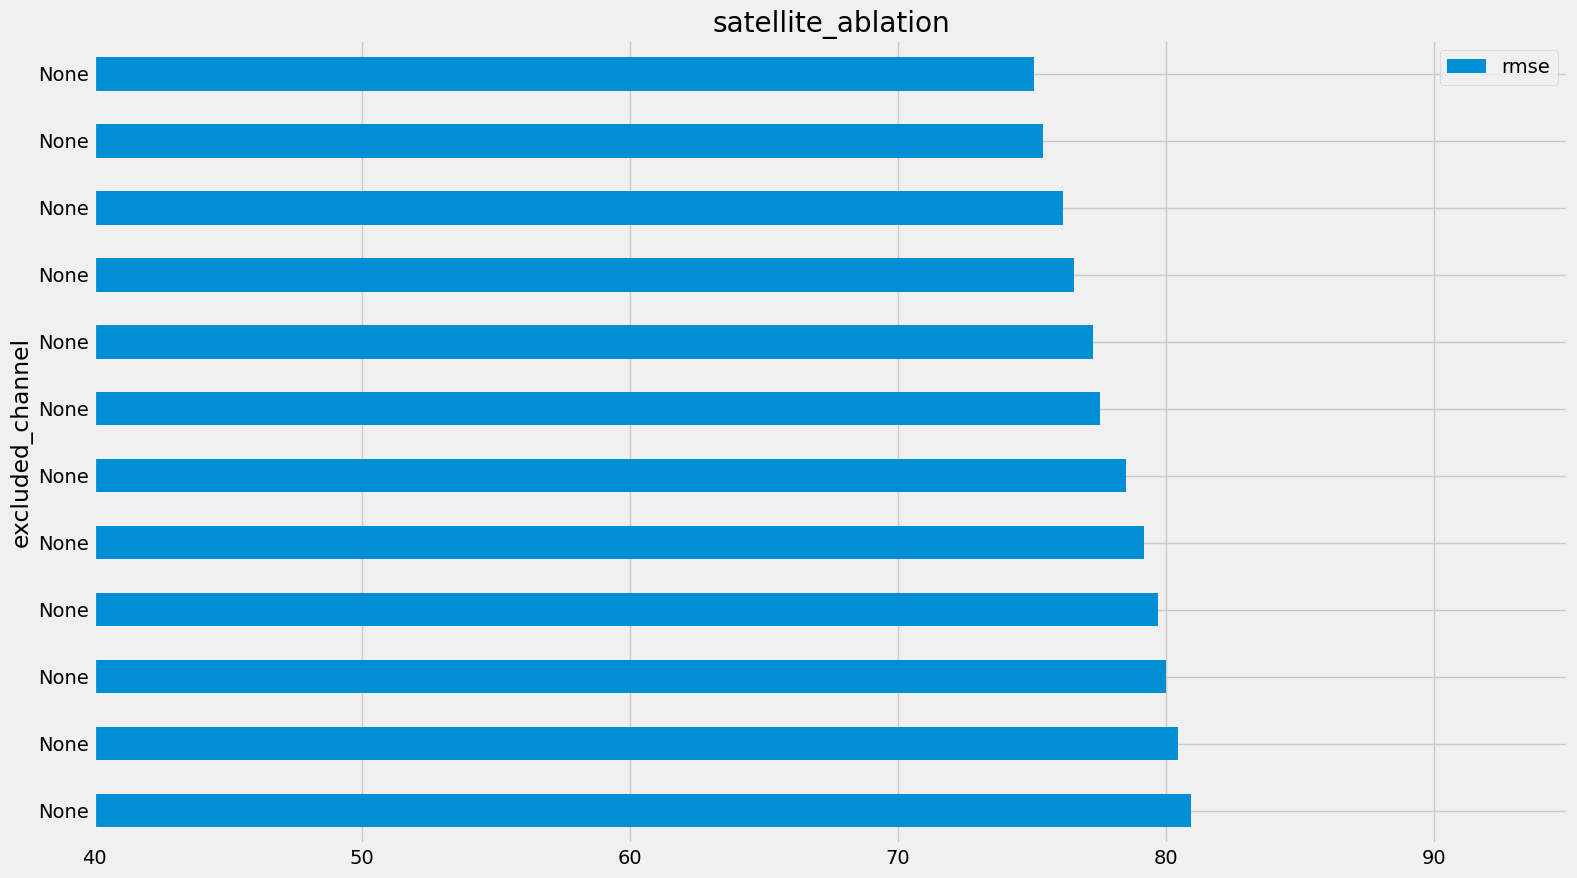

In [17]:
# plot 1
#### Satellite Ablation Barchart
param_dict, result_dict = plot_ablation(
    data_dir, id_="exclude_layer", title="satellite_ablation"
)
# tag fat i måned i stedet

In [18]:
param_dict

{0: {'num_input_channels': 15,
  'conv_filters1': 4,
  'conv_filters2': 8,
  'conv_filters3': 4,
  'num_dpoints': 5,
  'exclude_layer': None,
  'exclude_layer_name': 'No Layer Excluded',
  'num_epochs': 10},
 1: {'num_input_channels': 15,
  'conv_filters1': 8,
  'conv_filters2': 16,
  'conv_filters3': 16,
  'num_dpoints': 5,
  'exclude_layer': None,
  'exclude_layer_name': 'No Layer Excluded',
  'num_epochs': 10},
 2: {'num_input_channels': 15,
  'conv_filters1': 8,
  'conv_filters2': 16,
  'conv_filters3': 16,
  'num_dpoints': 5,
  'exclude_layer': None,
  'exclude_layer_name': 'No Layer Excluded',
  'num_epochs': 10},
 3: {'num_input_channels': 15,
  'conv_filters1': 16,
  'conv_filters2': 32,
  'conv_filters3': 16,
  'num_dpoints': 5,
  'exclude_layer': None,
  'exclude_layer_name': 'No Layer Excluded',
  'num_epochs': 10},
 4: {'num_input_channels': 15,
  'conv_filters1': 8,
  'conv_filters2': 16,
  'conv_filters3': 16,
  'num_dpoints': 5,
  'exclude_layer': None,
  'exclude_layer_

In [19]:
# plot 2
#### Channel Ablation Barchart
plot_ablation(channel_data_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'model_outputs/2023_05_07:17_16_42/'

## Code to fetch Data for evalutation

In [20]:
from collections import defaultdict
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import data_loader as dl


def load_single_SentinelDataset(
    fpath="large_subset.csv",
    max_chips=None,
    dir_tiles="large_sample/sentinel/",
    dir_target="large_sample/target/",
    dir_test="large_sample/test_features/",
):
    dataset = dl.SentinelDataset(
        tile_file=fpath,
        dir_tiles=dir_tiles,
        dir_target=dir_target,
        max_chips=max_chips,
        transform=None,
        device="cpu",
    )

    return dataset


def create_dataloader_from_indexes(indexes, fpath, exclude_layer=None, num_dpoints=100):
    input_ = []
    target_ = []

    dataset = load_single_SentinelDataset(fpath=fpath, max_chips=num_dpoints)
    if num_dpoints == None:
        num_dpoints = len(dataset)
    for i in tqdm(range(num_dpoints)):
        all_channels = [channel for channel in dataset.__getitem__(i)["image"]]
        if exclude_layer != None:
            if isinstance(exclude_layer, list):
                for idx, c in enumerate(exclude_layer):
                    all_channels.pop(c - idx)
            else:
                all_channels.pop(exclude_layer)

        input_.append(torch.stack(all_channels))
        target_.append(dataset.__getitem__(i)["label"])

    input_tensor = torch.stack([input_[idx] for idx in indexes])
    target_tensor = torch.stack([target_[idx] for idx in indexes])

    # Create a PyTorch data loader
    test_data = torch.utils.data.TensorDataset(input_tensor, target_tensor)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

    return test_loader


def predict(model, indexes, num_dpoints=100, fpath="large_subset.csv"):
    metrics = dict()
    # Define the loss function and optimizer
    criterion = nn.MSELoss(reduction="mean")
    loader = create_dataloader_from_indexes(indexes, fpath, num_dpoints=num_dpoints)

    cur_losses = []
    for i, (inputs, labels) in tqdm(enumerate(loader)):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        train_loss = np.round(np.sqrt(loss.item()), 5)
        cur_losses.append(train_loss)

    metrics["train_loss_median"] = np.median(cur_losses)
    metrics["train_loss_mean"] = np.mean(cur_losses)
    metrics["train_loss_std"] = np.std(cur_losses)

    return metrics

## Code to fetch Model for evalutation

In [21]:
from train_CNN import CNN
import torch


def get_model_args(args):
    CNN_params = [
        "num_input_channels",
        "conv_filters1",
        "conv_filters2",
        "conv_filters3",
    ]
    return {p: args[p] for p in CNN_params}


def get_best_model_index(idx, data_dir, eval_metrix="val_loss_median"):
    # idx references the index of the global configuration (i.e. ablation-setting)
    # model_outputs/study/[ablation_idx]/[config_idx]
    # This means that this function returns the best model for a given ablation study (fx excluding channel 0 or channel 1 or satellite 2...)

    config_dir = sorted(os.listdir(data_dir))[idx]

    dfs = {}
    configurations = {}
    for config_index in range(len(os.listdir(data_dir + config_dir))):
        df = pd.read_csv(
            data_dir + config_dir + "/" + str(config_index) + "/results.csv"
        )
        dfs[config_index] = df

        with open(
            data_dir + config_dir + "/" + str(config_index) + "/parameters.json", "r"
        ) as file:
            for line in file:
                conf = json.loads(line)

        configurations[config_index] = conf

    plt.style.use("fivethirtyeight")

    cur_min = 1000
    cur_min_index = 99
    best_agg = None
    for index, df in dfs.items():
        agg_df = aggregate_result(df, index)
        m = agg_df[eval_metrix].min()
        if m < cur_min:
            cur_min = m
            cur_min_index = index
            best_agg = agg_df

    return cur_min_index


def get_model_path(ablation_index, data_dir):
    bmx = get_best_model_index(ablation_index, data_dir)

    config_dir = os.listdir(data_dir)[ablation_index]

    return data_dir + config_dir + "/" + str(bmx) + "/model_state_dict"

# Compare performance across months
## First create subsets for the same n chips, for each month

In [22]:
# Create subsets for each month
import random

num_chips = 100


ls = (
    pd.read_csv("large_subset.csv", index_col=0)
    .drop_duplicates()
    .reset_index()
    .drop("index", axis=1)
    .sort_index(ascending=False)
)


for month in range(12):
    random_chip = random.choice(ls["chipid"].unique())

    indexes = []
    for chip in range(num_chips):
        ix = ls.loc[
            (ls["month"] == month) & (ls["chipid"] == random_chip)
        ].index.values[0]
        indexes.append(ix)

    ls.iloc[indexes].to_csv("subset_{}_{}.csv".format(num_chips, month))

## Select Model

In [23]:
study_dir = data_dir

# Chose a random model (e.g. excluding some layer)
# standard is to use the full model
ablation_index = 0

results, params = get_best_model(ablation_index, data_dir)


PATH = get_model_path(ablation_index, data_dir)

model_args = get_model_args(params)
model = CNN(**model_args)
model.load_state_dict(torch.load(PATH))
model.eval()

RuntimeError: Error(s) in loading state_dict for CNN:
	size mismatch for conv1.weight: copying a param with shape torch.Size([8, 15, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 15, 3, 3]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([16, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 4, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv3.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 8, 3, 3]).
	size mismatch for conv3.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for conv4.weight: copying a param with shape torch.Size([1, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 4, 3, 3]).

## Then evaluate the mode on each

100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.61it/s]
100it [00:00, 224.89it/s]
100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.58it/s]
100it [00:00, 219.49it/s]
100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.27it/s]
100it [00:00, 208.13it/s]
100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.04it/s]
100it [00:00, 189.43it/s]
100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.25it/s]
100it [00:00, 220.99it/s]
100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.79it/s]
100it [00:00, 201.65it/s]
100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.60it/s]
100it [00:00, 193.96it/s]
100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.27it/s]
100it [00:00, 227.73it/s]
100%|███

AttributeError: module 'matplotlib.pyplot' has no attribute 'save_fig'

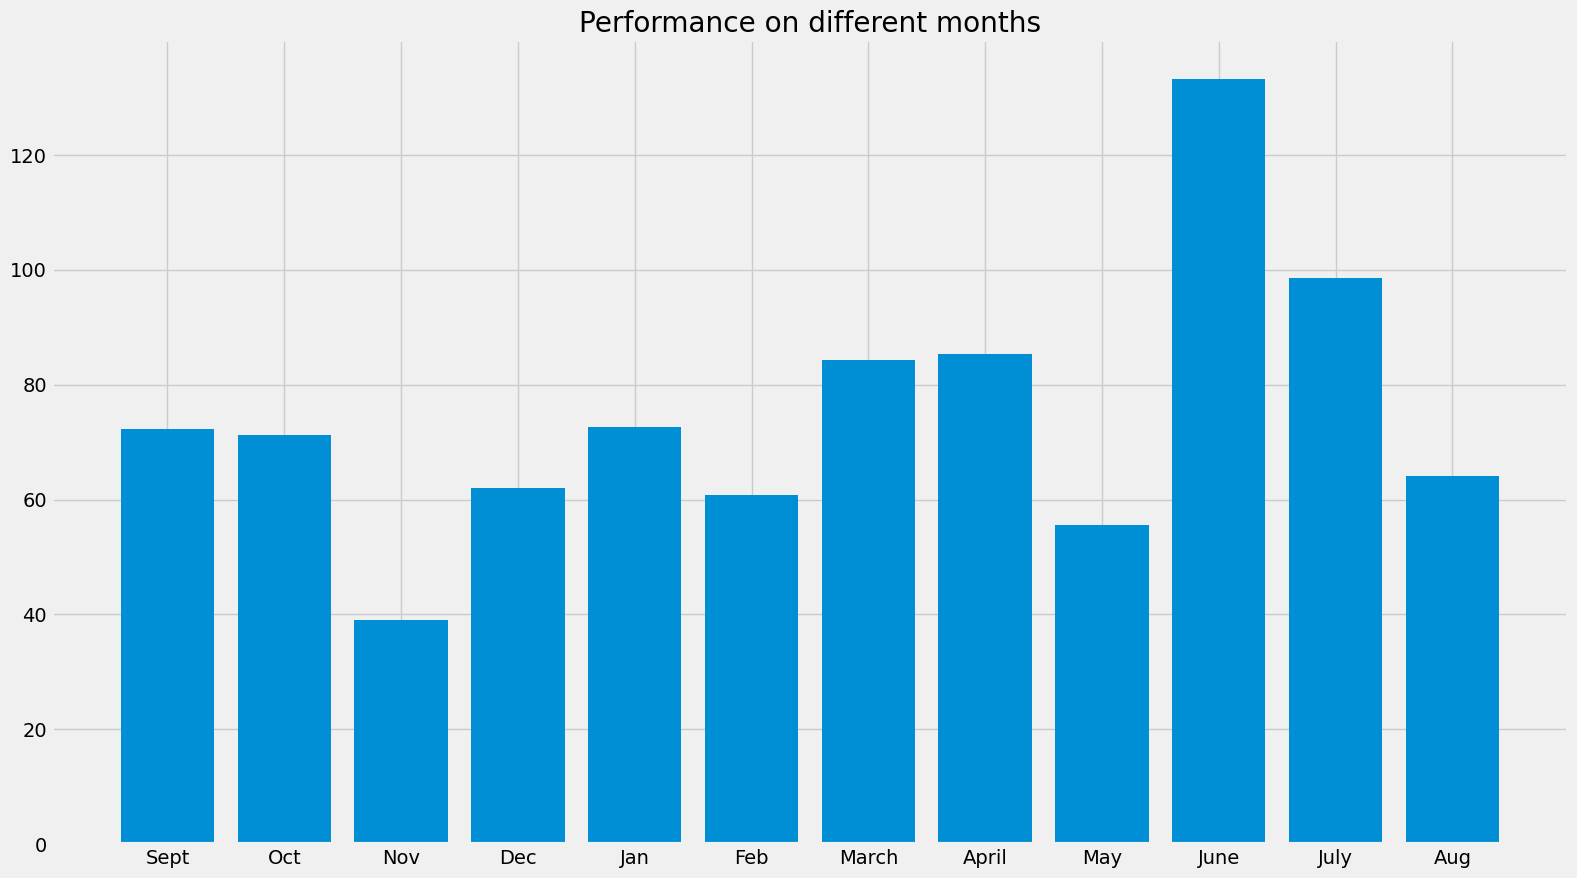

In [ ]:
perfs = []

for month in range(12):
    fpath = "subset_100_{}.csv".format(month)
    perfs.append(
        predict(model, indexes=[i for i in range(100)], num_dpoints=100, fpath=fpath)
    )


y = [p["train_loss_median"] for p in perfs]

months = [
    "Sept",
    "Oct",
    "Nov",
    "Dec",
    "Jan",
    "Feb",
    "March",
    "April",
    "May",
    "June",
    "July",
    "Aug",
]

plt.figure(figsize=[16, 9])
plt.bar(x=months, height=y)
plt.title("Performance on different months")
plt.tight_layout()
plt.savefig("months.png")
plt.show()

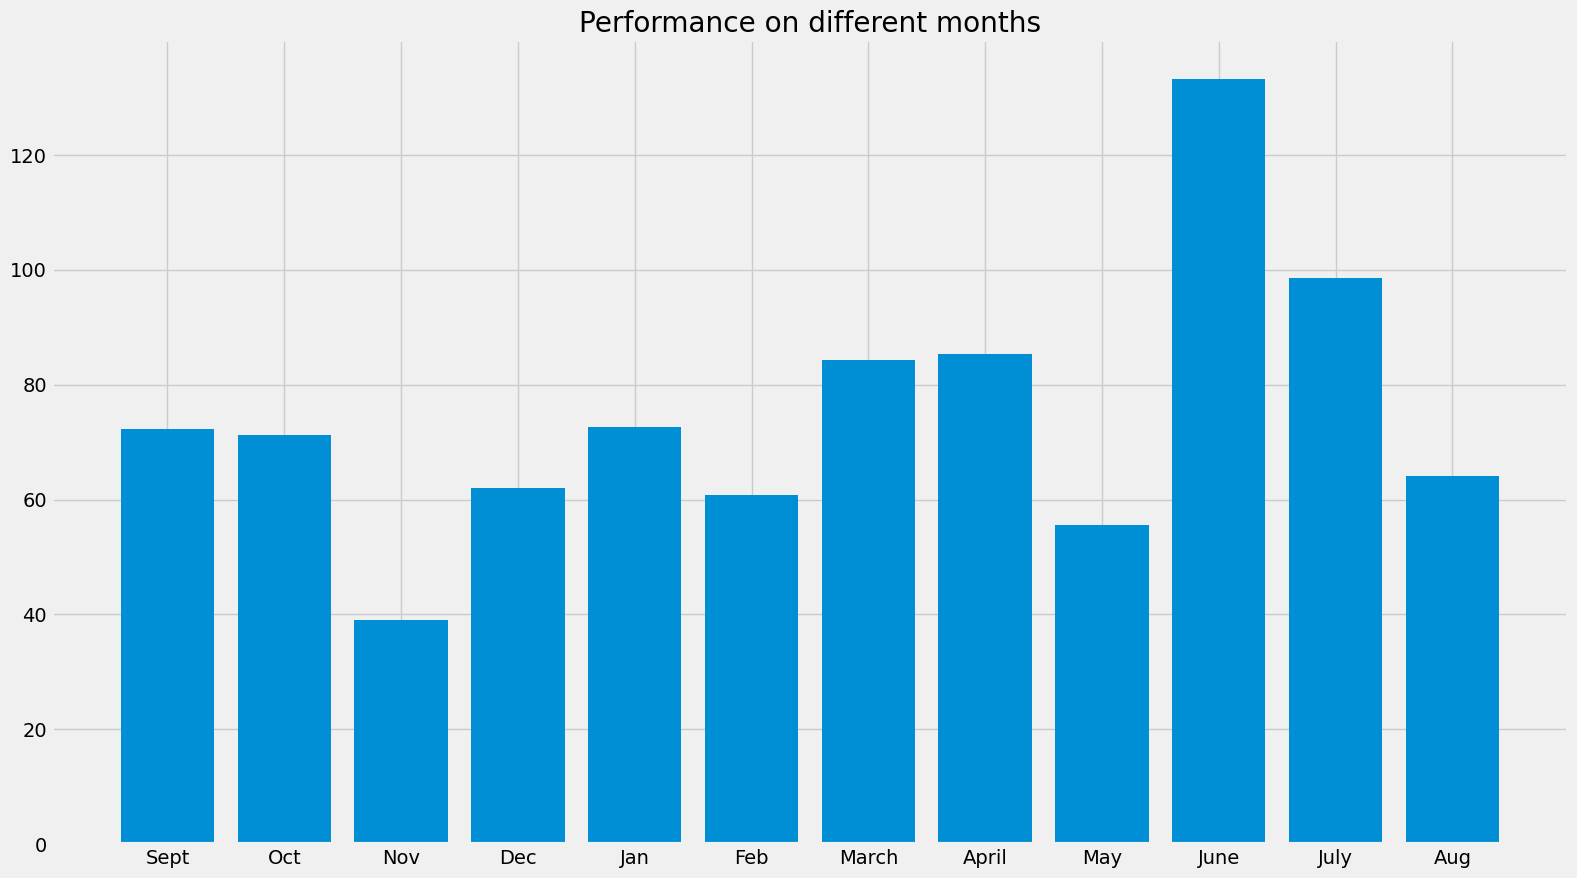

In [ ]:
plt.figure(figsize=[16, 9])
plt.bar(x=months, height=y)
plt.title("Performance on different months")
plt.tight_layout()
plt.savefig("months.png")
plt.show()

In [ ]:
!open .